In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization, Input, Conv2D
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, ReLU, LeakyReLU

In [2]:
from sklearn.model_selection import train_test_split

## Data donwloading and preprocessing

In [2]:
metadata = pd.read_csv('train.csv')
metadata = metadata.rename(columns={'Id': 'id', 'Target': 'target'})

submission = pd.read_csv('sample_submission.csv')
submission = submission.rename(columns={'Id': 'id', 'Target': 'target'})

In [3]:
labels = {
    '0' : 'Nucleoplasm', 
    '1' : 'Nuclear membrane',   
    '2' : 'Nucleoli', 
    '3' : 'Nucleoli fibrillar center',   
    '4' : 'Nuclear speckles',   
    '5' : 'Nuclear bodies',   
    '6' : 'Endoplasmic reticulum',   
    '7' : 'Golgi apparatus',   
    '8' : 'Peroxisomes',   
    '9' : 'Endosomes',   
    '10' : 'Lysosomes',   
    '11' : 'Intermediate filaments',   
    '12' : 'Actin filaments',   
    '13' : 'Focal adhesion sites',  
    '14' : 'Microtubules',   
    '15' : 'Microtubule ends',   
    '16' : 'Cytokinetic bridge',   
    '17' : 'Mitotic spindle',   
    '18' : 'Microtubule organizing center',   
    '19' : 'Centrosome',   
    '20' : 'Lipid droplets',   
    '21' : 'Plasma membrane',   
    '22' : 'Cell junctions',   
    '23' : 'Mitochondria',   
    '24' : 'Aggresome',   
    '25' : 'Cytosol',   
    '26' : 'Cytoplasmic bodies',   
    '27' : 'Rods & rings',  
}

channels = {
    0: 'Microtubules',
    1: 'Nucleus',
    2: 'Protein',
    3: 'Endoplasmic reticulum'
}

channels_marker = {
    0: 'Red',
    1: 'Blue',
    2: 'Green',
    3: 'Yellow'
}

cmap_markers = {
    0: 'Reds',
    1: 'Blues',
    2: 'Greens',
    3: 'YlOrBr'
}

In [5]:
metadata = pd.concat([metadata, 
           pd.get_dummies(metadata.target.apply(lambda x: x.split()).apply(pd.Series).stack()).sum(level=0).sort_index(axis=1)],
         axis=1)
metadata = metadata.drop(columns='target')
metadata = metadata.rename(columns=labels)

In [7]:
def download_data(names, folder='train', f='png'):
    data = []
    for name in names:
        full_name = os.path.join(os.getcwd(), folder, name)
        image_red = np.array(Image.open(full_name + '_red.' + f))
        image_blue = np.array(Image.open(full_name + '_blue.' + f))
        image_green = np.array(Image.open(full_name + '_green.' + f))
        image_yellow= np.array(Image.open(full_name + '_yellow.' + f))
        image = np.dstack((image_red, image_blue, image_green, image_yellow))
        data.append(image)
    data = np.array(data)
    return data

def labels_to_str(labels_tensor, mapping=labels):
    '''labels_tensor - batch_size x 27 matrix with labels'''
    '''result: string view of the labels'''
    result = map(lambda x: '\n'.join(list(map(lambda y: mapping[y], 
                                               np.where(x == 1)[0].astype(str)))), 
                 labels_tensor)
    result = list(result)
    return result 

def generate_batch(batch_size=3, metadata=metadata):
    n_batches = np.ceil(metadata.shape[0] / batch_size).astype(int)
    for i in range(n_batches):
        labels = metadata.iloc[i*(batch_size): (i+1)*batch_size].iloc[:, 1:].values
        names = metadata.iloc[i*(batch_size): (i+1)*batch_size].id
        yield download_data(names), labels
        
def plot_samples(data):
    samples, labels = data
    labels_str = labels_to_str(labels)
    n_samples = samples.shape[0]
    n_channels = samples.shape[-1]
    fig, axes = plt.subplots(n_samples, n_channels+1, figsize=(16, 16))
    for i in range(n_samples):
        for j in range(n_channels):
            axes[i, j].set_title(labels_str[i])
            axes[i, j].set(xlabel=channels[j], ylabel=channels_marker[j])
            axes[i, j].imshow(samples[i, :, :, j], cmap=cmap_markers[j])
        axes[i, n_channels].set_title('RGB image')
        axes[i, n_channels].imshow(samples[i, :, :, :-1])
        
def plot_rgb(data):
    samples, labels = data
    labels_str = labels_to_str(labels)
    n_samples = samples.shape[0]
    fig, axes = plt.subplots(1, n_samples, figsize=(16, 16))
    for j in range(n_samples):
        axes[j].set_title(labels_str[j])
        axes[j].set(xlabel='RGB')
        axes[j].imshow(samples[j, :, :, :-1])

In [8]:
gen = generate_batch(batch_size=3)

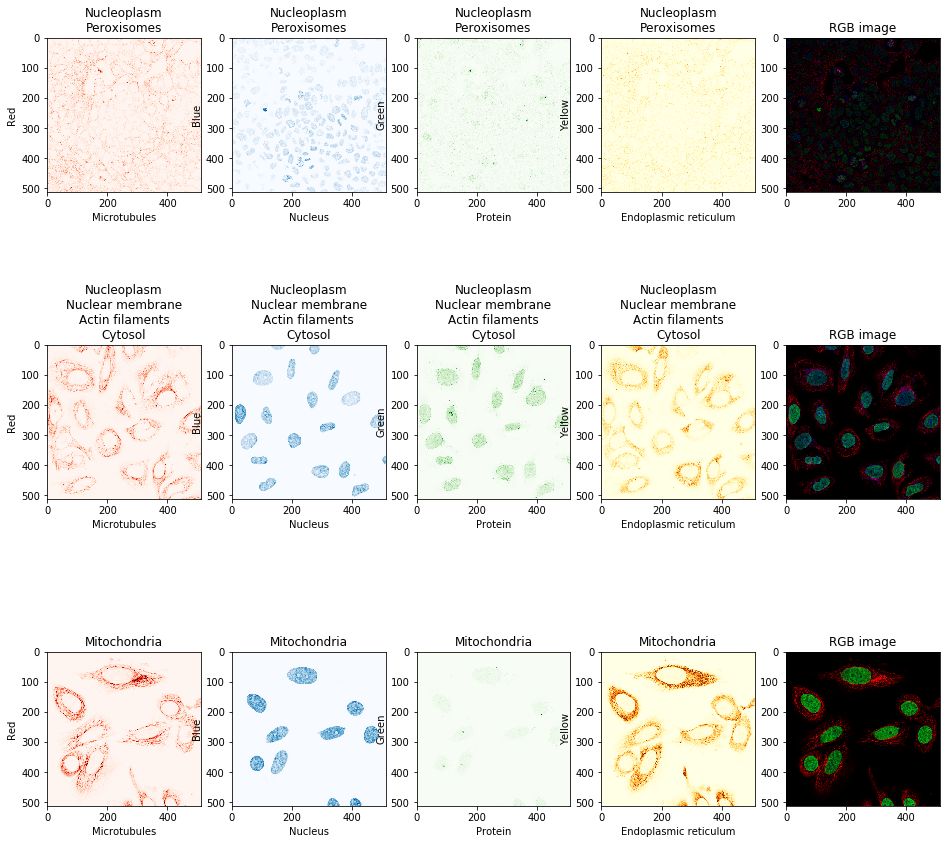

In [9]:
data = next(gen)
plot_samples(data)

## Convert from PNG to JPG

In [5]:
from PIL import Image
os.mkdir('train_jpegs')
f = 'png'
g = 'jpg'
for i, full_name in enumerate(metadata.id):
    if i % 1000 == 0:
        print(i)
    image_red = Image.open('train/' + full_name + '_red.' + f)
    image_blue = Image.open('train/' + full_name + '_blue.' + f)
    image_green = Image.open('train/' + full_name + '_green.' + f)
    image_yellow= Image.open('train/' + full_name + '_yellow.' + f)
    
    image_red.save('train_jpegs/' + full_name + '_red.' + g, 'JPEG', quality=100, optimize=True, progressive=True)
    image_blue.save('train_jpegs/' + full_name + '_blue.' + g, 'JPEG', quality=100, optimize=True, progressive=True)
    image_green.save('train_jpegs/' + full_name + '_green.' + g, 'JPEG', quality=100, optimize=True, progressive=True)
    image_yellow.save('train_jpegs/' + full_name + '_yellow.' + g, 'JPEG', quality=100, optimize=True, progressive=True)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000


In [ ]:
os.mkdir('test_jpegs')
f = 'png'
g = 'jpg'
for i, full_name in enumerate(metadata.id):
    if i % 1000 == 0:
        print(i)
    image_red = Image.open('test/' + full_name + '_red.' + f)
    image_blue = Image.open('test/' + full_name + '_blue.' + f)
    image_green = Image.open('test/' + full_name + '_green.' + f)
    image_yellow= Image.open('test/' + full_name + '_yellow.' + f)
    
    image_red.save('test_jpegs/' + full_name + '_red.' + g, 'JPEG', quality=100, optimize=True, progressive=True)
    image_blue.save('test_jpegs/' + full_name + '_blue.' + g, 'JPEG', quality=100, optimize=True, progressive=True)
    image_green.save('test_jpegs/' + full_name + '_green.' + g, 'JPEG', quality=100, optimize=True, progressive=True)
    image_yellow.save('test_jpegs/' + full_name + '_yellow.' + g, 'JPEG', quality=100, optimize=True, progressive=True)

## Compression

In [3]:
import cv2
from zipfile import ZipFile, ZIP_DEFLATED
from scipy.misc import imresize

In [13]:
os.mkdir('train_comp')
os.mkdir('test_comp')

In [31]:
images = []
for name in metadata.id:
    
    image = download_data([name], folder='train')
    image = imresize(image[0, :, :, :], size=(128, 128), interp='bilinear')

    images.append(image)

images = np.array(images)
np.save('train_compressed.npy', images)

/home/vaden4d/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


KeyboardInterrupt: 

In [8]:
images = []
for i, name in enumerate(submission.id):
    
    if i % 1000 == 0:
        print(i)
        
    image = download_data([name], folder='test')
    image = imresize(image[0, :, :, :], size=(256, 256), interp='bilinear')

    images.append(image)

images = np.array(images)
np.save('test256.npy', images)

0


/home/vaden4d/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


MemoryError: 

In [ ]:
images = np.load('../input/train128.npy')
labels = metadata.iloc[:, 1:].values

## Data modeling

In [7]:
# some basic useless model
def create_model(input_shape):
    
    dropRate = 0.4
    
    init = Input(input_shape)
    x = BatchNormalization(axis=-1)(init)
    x = Conv2D(8, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(8, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(16, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    c1 = Conv2D(16, (3, 3), padding='same')(x)
    c1 = ReLU()(c1)
    c2 = Conv2D(16, (5, 5), padding='same')(x)
    c2 = ReLU()(c2)
    c3 = Conv2D(16, (7, 7), padding='same')(x)
    c3 = ReLU()(c3)
    c4 = Conv2D(16, (1, 1), padding='same')(x)
    c4 = ReLU()(c4)
    x = Concatenate()([c1, c2, c3, c4])
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    x = Conv2D(32, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    x = Conv2D(64, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    #x = Conv2D(256, (1, 1), activation='relu')(x)
    #x = BatchNormalization(axis=-1)(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(28)(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(0.1)(x)
    x = Dense(28)(x)
    x = Activation('sigmoid')(x)
    
    model = Model(init, x)
    
    return model

In [8]:
model = create_model((128, 128, 4))

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 4)  0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 4)  16          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 126, 126, 8)  296         batch_normalization_2[0][0]      
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 126, 126, 8)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [10]:
from tensorflow import where, is_nan, zeros_like, ones_like, equal
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = where(is_nan(f1), zeros_like(f1), f1)
    return K.mean(f1)

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = where(equal(y_true, 1), y_pred, ones_like(y_pred))
        pt_0 = where(equal(y_true, 0), y_pred, zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

fl = focal_loss()

In [11]:
checkpoint = ModelCheckpoint('InceptionV3.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.1, 
                                   patience=3, 
                                   verbose=1, 
                                   mode='auto', 
                                   epsilon=0.0001)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6)
callbacks_list = [checkpoint, early, reduceLROnPlat]

/home/vaden4d/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [12]:
epochs = 20
batch_size = 16

In [30]:
images_train, labels_train, images_test, labels_test = train_test_split(images, labels, test_size=0.2)

In [32]:
model.compile(loss=[fl],
            optimizer=Adam(lr=1e-4),
            metrics=[f1])

In [33]:
model.fit(images_train, 
          labels_train, 
          batch_size, 
          epochs, 
          callbacks=callbacks_list, 
          validation_data=(images_test, labels_test))

Epoch 1/20
1554/1554 [==============================] - 3686s 2s/step - loss: 10.0400 - f1: 0.0086 - val_loss: 7.7767 - val_f1: 0.0000e+00

Epoch 00001: val_loss improved from inf to 7.77665, saving model to InceptionV3.h5
Epoch 2/20


StopIteration: 

## Inference

In [ ]:
images = np.load('/proteins128/train128.npy') 
labels = metadata.iloc[:, 1:].values

_, images, _, labels = train_test_split(images, labels, test_size=0.2, random_state=52)